<a href="https://colab.research.google.com/github/KelvinLam05/k-means_clustering/blob/main/k-means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project** 

In this project, we will try to analyze the types of customers in the market according to their characteristics. The dataset consists of 30 samples and their characteristics are satisfaction and loyalty respectively. To put it simply, we will cluster customers based on their satisfaction and loyalty with the customer data we have.

**K-means clustering**

K-means is one of the most widely used algorithms for clustering data and falls into the unsupervised learning group of machine learning models. It’s ideal for many forms of customer segmentation.

**Assumptions in k-means clustering**

The k means algorithm makes several assumptions about the data that are important to understand.

* The mean and standard deviation of the values should be similar.

* K-means expects the distribution of each variable to be normal, not highly skewed.

* It also expects data to form spherical clusters of roughly similar size.

**Load the packages**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

**Load the data**

In [2]:
# Load dataset
df = pd.read_csv('/content/market_segmentation.csv')

In [3]:
# Change the data frame's column names to lower case
df.columns = df.columns.str.lower()

In [4]:
# Examine the data
df.head()

,satisfaction,loyalty
0,4,-1.33
1,6,-0.28
2,5,-0.99
3,7,-0.29
4,4,1.06


In [5]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   satisfaction  30 non-null     int64  
 1   loyalty       30 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 608.0 bytes


**Check for missing values**

df.isnull( ).sum( ) shows us that we don’t have any null values.

In [6]:
df.isnull().sum()

satisfaction    0
loyalty         0
dtype: int64

**Normality**

* A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. 
* A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. 
* A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [7]:
skewness = df.skew().sort_values(ascending = False)

In [8]:
pd.DataFrame({'skewness': skewness})

,skewness
loyalty,-0.277033
satisfaction,-0.285179


We can see that 'loyalty' and 'satisfaction' are normally distributed.

**Scale the data**

To ensure the variables have a similar mean and standard deviation we can use the StandardScaler from scikit-learn.

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# Standarize features
scaler = StandardScaler()
scaler.fit(df)
df_norm = scaler.transform(df)

**The Kneedle algorithm**

When using the k means clustering algorithm, we need to specifically define k, or the number of clusters we want the algorithm to create. Rather than selecting an arbitrary value, such as the number of clusters we want for practical purposes, there’s a science to the selection of the optimum k.

We’ll use the Kneedle algorithm here via Kevin Arvai’s excellent Python implementation called [Kneed](https://pypi.org/project/kneed/).

The Kneedle algorithm is a generic tool designed for the detection of “knees” in data. In clustering, the knee represents the point at which adding further clustering fails to add significantly more detail.

In [11]:
from sklearn.cluster import KMeans

In [12]:
# A list holds the SSE values for each k
sse = []

K = range(1, 10)

for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(df_norm)
    sse.append(km.inertia_)

In [14]:
from kneed import KneeLocator

In [15]:
kl = KneeLocator(range(1, 10), sse, curve = 'convex', direction = 'decreasing')

Using the Kneedle algorithm on our df_norm dataframe returns a value of 4, which is what we should use as our k value to get the optimum results.

In [16]:
kl.elbow

4

**Apply k-means clustering**

In [17]:
# Create k-mean object
kmeans = KMeans(n_clusters = 4, random_state = 42)

# Train model
kmeans.fit(df_norm)

# Predict class
df = df.assign(cluster = kmeans.labels_)

In [18]:
df = df.sort_values(by = 'cluster', ascending = True)

**Examining the customer segments**

To examine the clusters generated, we can use a groupby( ) on the newly created cluster column and then use the agg( ) function to calculate summary statistics for each cluster.

This gives us four clear clusters. The clusters created are fairly easy to distinguish, but this doesn’t mean that four represents the optimum number of clusters for practical marketing purposes.

In [19]:
df.groupby('cluster').agg(satisfaction = ('satisfaction', 'mean'), loyalty = ('loyalty', 'mean'), cluster_size = ('cluster', 'count'))

,satisfaction,loyalty,cluster_size
cluster,,,
0,3.428571,-1.382857,7
1,4.333333,0.820000,6
2,8.111111,-0.358889,9
3,8.625000,1.002500,8


Let's visualize the results by plotting the data colored by these labels.

In [21]:
import plotly.express as px
from gitly.colab.plot import GitlyPlotter

In [22]:
gitly = GitlyPlotter('github')

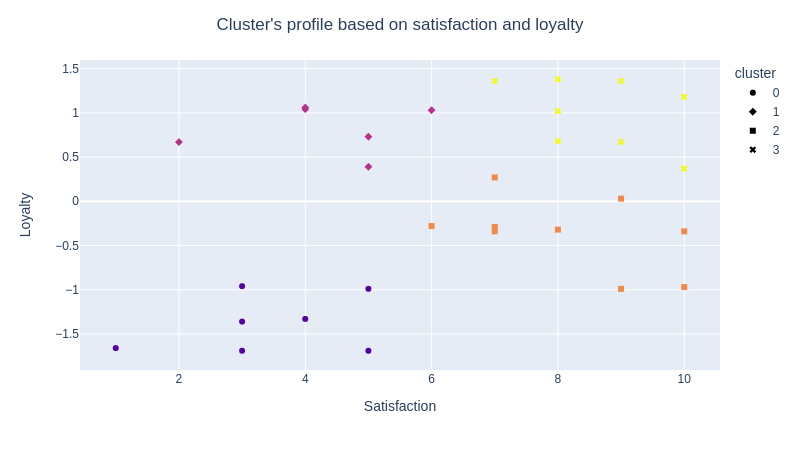

In [23]:
fig = px.scatter(df, x = 'satisfaction', y = 'loyalty', color = 'cluster', symbol = 'cluster')

fig.update_layout(title_text = "Cluster's profile based on satisfaction and loyalty", title_x = 0.5)

fig.update_layout(xaxis_title = 'Satisfaction')
fig.update_layout(yaxis_title = 'Loyalty')

fig.update(layout_coloraxis_showscale = False)

gitly.show(fig)

As illustrated in the above plot, we can get the following information for each of the segments:

**0.** customers with **low** satisfaction and **low** loyalty

**1.** customers with **medium** satisfaction and **high** loyalty

**2.** customers with **high** satisfaction and **low** loyalty

**3.** customers with **high** satisfaction and **high** loyalty

**From Apostles to Terrorists**

A popular model that provides a differentiated view of customer loyalty is the Apostle Model, developed at Harvard Business School. Based on satisfaction and loyalty, this approach segments customers into four quadrants: Loyalists, Hostages, Mercenaries, and Defectors.

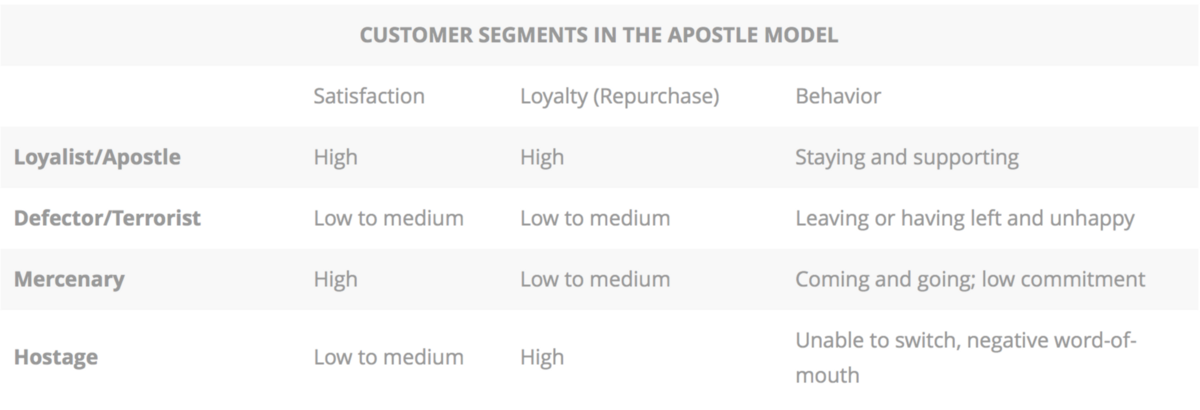

**Labeling the customers by segment**

Finally, to make our new segments a bit easier for non-technical marketers to understand, we can assign them each a label indicating their approximate value to the business. 

In [24]:
segments = {0: 'Defectors/Terrorists', 1: 'Hostage', 2: 'Mercenaries', 3: 'Loyalists/Apostles'}
df['segment'] = df['cluster'].map(segments)
df.head()

,satisfaction,loyalty,cluster,segment
0,4,-1.33,0,Defectors/Terrorists
2,5,-0.99,0,Defectors/Terrorists
23,3,-0.96,0,Defectors/Terrorists
5,1,-1.66,0,Defectors/Terrorists
21,3,-1.69,0,Defectors/Terrorists
